# 第9回の宿題の回答例

## スズキ様用の各パーツの月次ワランティ数について、SARIMAを用いて、tainingデータを使ってモデルを訓練し、validation期間について予測を行ってみてください。

8.2.2の宿題と重複するので、そちらを参照。(すみません、よく確認していませんでした)

### FYI: ちなみに、statsmodelsの線形ローカルトレンド + サイクルを使うと、以下のようなイメージ 

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

PATH_DATA_INTERIM = Path("../data/interim/")

In [4]:
df_warranty_model_part_num_daily = pd.read_feather(PATH_DATA_INTERIM/"df_warranty_model_part_num_daily.feather")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [5]:
selected_part_S = ["46860-76G", "95200-58J", "37990-72J", "09262-350",
                   "17400-588"]

In [6]:
ts_dict_S = {}
ts_dict_monthly_S = {}
for part in selected_part_S:
    ts_tmp = (df_warranty_model_part_num_daily
              .loc[df_warranty_model_part_num_daily.part_cd == part,
                          ["date", "n"]]
              .groupby("date")["n"]
              .sum())
    ts_tmp.index = pd.to_datetime(ts_tmp.index)
    ts_dict_S[part] = ts_tmp
    ts_dict_monthly_S[part] = ts_tmp.resample("MS").sum()

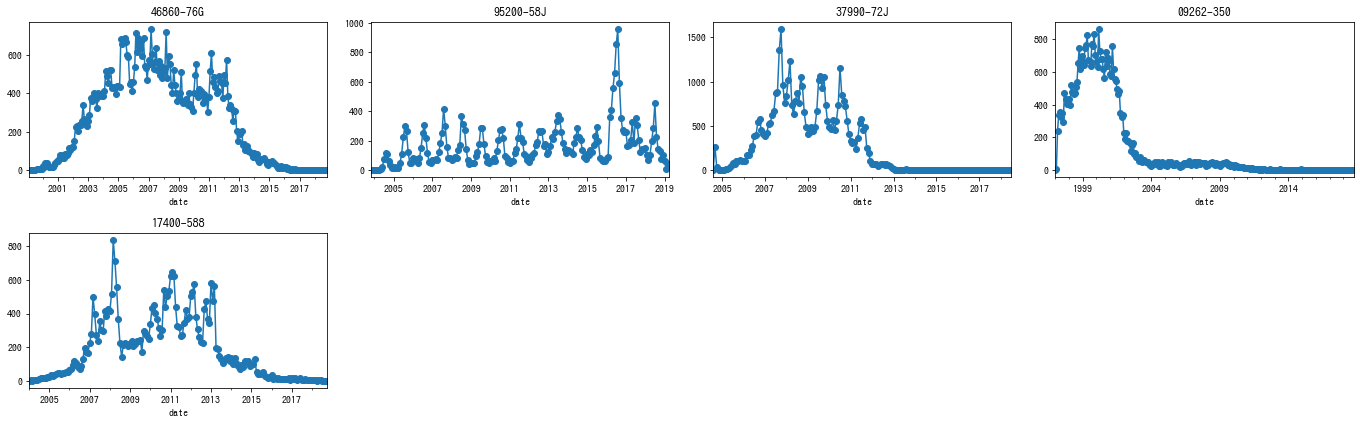

In [9]:
fig = plt.figure(figsize=(19,6))
for i, (part, ts) in enumerate(ts_dict_monthly_S.items()):
    ax = fig.add_subplot(2,4,i+1)
    ts.plot(style="-o", title=part, ax=ax)

plt.tight_layout()

In [10]:
df_term_devide = pd.DataFrame([{"part":"46860-76G", "valid_start":"2009-01-01", "test_start":"2010-01-01"},
                               {"part":"95200-58J", "valid_start":"2015-01-01", "test_start":"2016-01-01"},
                               {"part":"37990-72J", "valid_start":"2009-01-01", "test_start":"2010-01-01"},
                               {"part":"09262-350", "valid_start":"2000-01-01", "test_start":"2001-01-01"},
                               {"part":"17400-588", "valid_start":"2011-01-01", "test_start":"2012-01-01"}])
df_term_devide.set_index("part", inplace=True)
df_term_devide["valid_start"] = pd.to_datetime(df_term_devide.valid_start)
df_term_devide["test_start"] = pd.to_datetime(df_term_devide.test_start)

In [13]:
from datetime import datetime, timedelta

ts_dict_monthly_S_train, ts_dict_monthly_S_valid, ts_dict_monthly_S_test = {},{},{}

for part in selected_part_S:
    valid_start = df_term_devide.loc[part, "valid_start"]
    test_start = df_term_devide.loc[part, "test_start"]
    train_end = valid_start - timedelta(1)
    valid_end = test_start - timedelta(1)
    
    ts_dict_monthly_S_train[part] = ts_dict_monthly_S[part].loc[:train_end]
    ts_dict_monthly_S_valid[part] = ts_dict_monthly_S[part].loc[valid_start:valid_end]
    ts_dict_monthly_S_test[part] = ts_dict_monthly_S[part].loc[test_start:]

In [14]:
from statsmodels.tsa.statespace.structural import 

#### そのまま

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


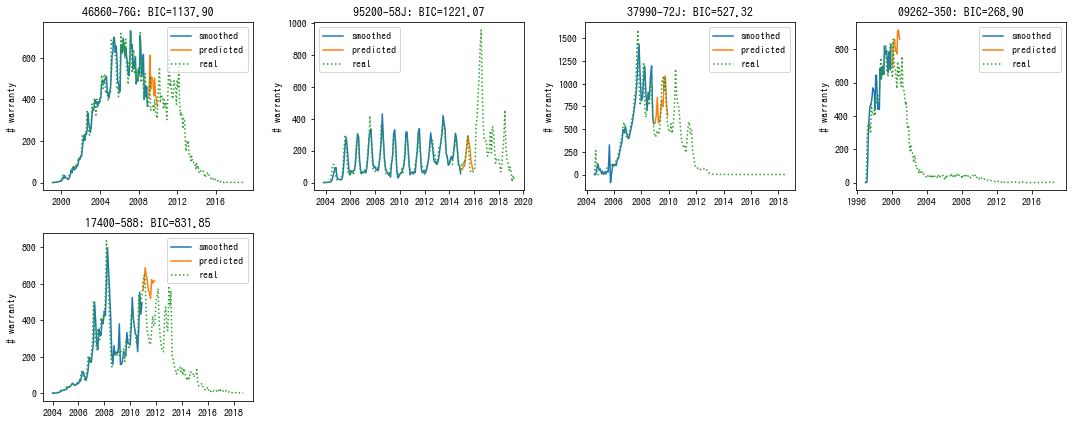

In [92]:
fig = plt.figure(figsize=(15,6))
for i,part in enumerate(selected_part_S):
    m_dlm = UnobservedComponents(ts_dict_monthly_S_train[part], 'local linear trend', 
                             freq_seasonal=[{"period":12}]).fit()
    pred = m_dlm.predict()
    ax = fig.add_subplot(2,4,i+1)
    ax.plot(pred.index, pred.values, label="smoothed")
    forc = m_dlm.forecast(12)
    ax.plot(forc.index, forc.values, label="predicted")
    ax.plot(ts_dict_monthly_S[part].index, ts_dict_monthly_S[part].values,
            ":", label="real")
    plt.legend()
    ax.set(ylabel="# warranty", title=f"{part}: BIC={m_dlm.bic:.2f}")
plt.tight_layout()

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


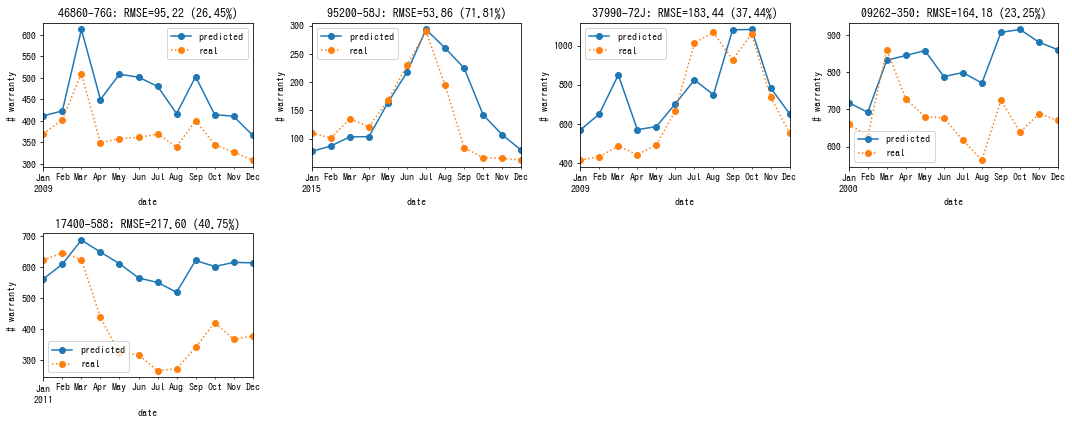

In [96]:
fig = plt.figure(figsize=(15,6))
for i,part in enumerate(selected_part_S):
    m_dlm = UnobservedComponents(ts_dict_monthly_S_train[part], 'local linear trend', 
                             freq_seasonal=[{"period":12}]).fit()
    ax = fig.add_subplot(2,4,i+1)
    pred = m_dlm.forecast(12)
    pred.plot(ax=ax, style="o-", label="predicted")
    ts_dict_monthly_S_valid[part].plot(ax=ax, style="o:", label="real")
    ax.legend()
    err = ts_dict_monthly_S_valid[part] - pred
    rmse = np.sqrt((err**2).mean())
    rmse_ratio = rmse / ts_dict_monthly_S_train[part][-1]
    ax.set(ylabel="# warranty", 
           title=f"{part}: RMSE={np.sqrt((err**2).mean()):.2f} ({rmse_ratio:.2%})")

plt.tight_layout()

#### 対数変換

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


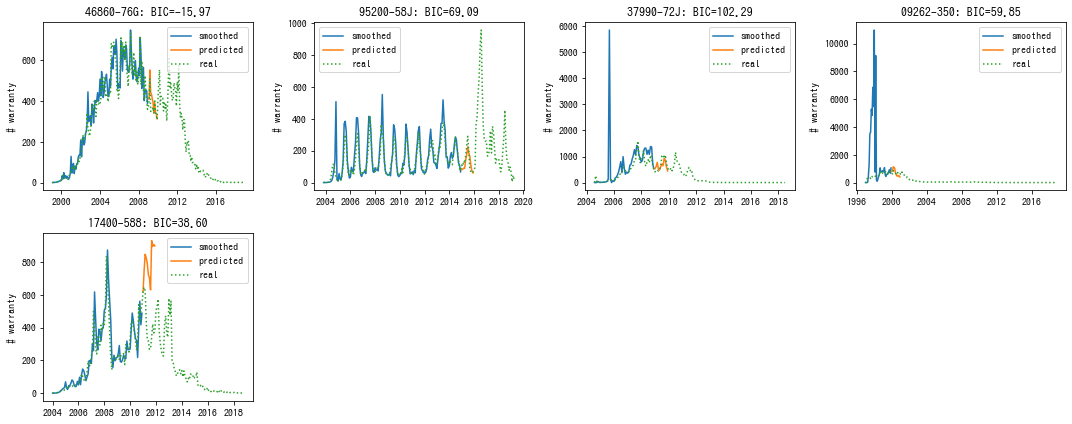

In [98]:
fig = plt.figure(figsize=(15,6))
for i,part in enumerate(selected_part_S):
    m_dlm = UnobservedComponents(np.log1p(ts_dict_monthly_S_train[part]), 'local linear trend', 
                             freq_seasonal=[{"period":12}]).fit()
    pred = np.expm1(m_dlm.predict())
    ax = fig.add_subplot(2,4,i+1)
    ax.plot(pred.index, pred.values, label="smoothed")
    forc = np.expm1(m_dlm.forecast(12))
    ax.plot(forc.index, forc.values, label="predicted")
    ax.plot(ts_dict_monthly_S[part].index, ts_dict_monthly_S[part].values,
            ":", label="real")
    plt.legend()
    ax.set(ylabel="# warranty", title=f"{part}: BIC={m_dlm.bic:.2f}")
plt.tight_layout()

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


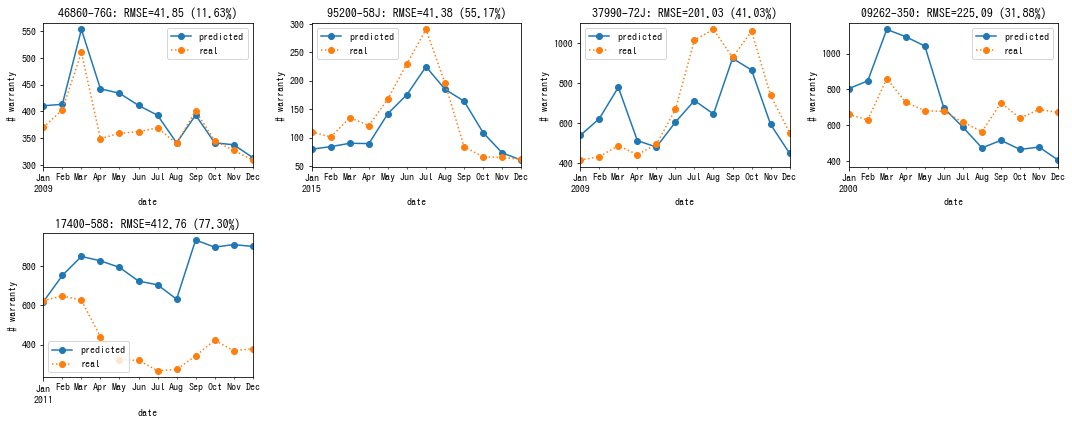

In [99]:
fig = plt.figure(figsize=(15,6))
for i,part in enumerate(selected_part_S):
    m_dlm = UnobservedComponents(np.log1p(ts_dict_monthly_S_train[part]), 'local linear trend', 
                             freq_seasonal=[{"period":12}]).fit()
    ax = fig.add_subplot(2,4,i+1)
    pred = np.expm1(m_dlm.forecast(12))
    pred.plot(ax=ax, style="o-", label="predicted")
    ts_dict_monthly_S_valid[part].plot(ax=ax, style="o:", label="real")
    ax.legend()
    err = ts_dict_monthly_S_valid[part] - pred
    rmse = np.sqrt((err**2).mean())
    rmse_ratio = rmse / ts_dict_monthly_S_train[part][-1]
    ax.set(ylabel="# warranty", 
           title=f"{part}: RMSE={np.sqrt((err**2).mean()):.2f} ({rmse_ratio:.2%})")

plt.tight_layout()

## Aさんは夜に流れ星を見ていました。6時間夜空を眺めていたところ、各時間の流れ星の観測数は以下の通りでした。単位時間あたりの流れ星の平均発生数$\lambda$は一定だとして、最尤推定を用いて$\lambda$を推定して下さい。

In [2]:
n_metheor = [1, 3, 6, 2, 0, 2] # 個

発生確率の低い事象の単位時間あたりの発生回数は、ポアソン分布によって良く近似できることが多い。  
ポアソン分布のパラメータは平均値$\lambda$であるので、ざっくりと平均値を計算して、あたりをつける

In [48]:
np.array(n_metheor).mean()

2.3333333333333335

パラメータは2.33は近辺になりそう(というより、今回のデータのみで最尤推定をすると、2.33になる。)

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


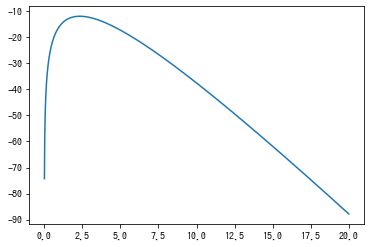

In [34]:
from scipy.stats import poisson # ポアソン分布

x = np.linspace(0,20,2001) # パラメータの候補。0, 0.01, 0.02, ..., 20

log_likelihood_list = [0] * 2001 # 対数尤度の入れ物
for i,val in enumerate(x):
    log_likelihood_list[i] = np.sum(np.log(poisson.pmf(n_metheor, mu=val))) # 対数尤度を計算して、リストに代入

plt.plot(x, log_likelihood_list)

In [35]:
x[np.argmax(log_likelihood_list)] # np.argmaxで最大値を取るときの配列indexを探して、そのときのxをとってくる

2.33

よって答えは2.33。  
scipyのoptimizerを使用してもよい。

In [36]:
from scipy.optimize import minimize

def neg_log_likelihood(lam):
    return -np.sum(np.log(poisson.pmf(n_metheor, mu=lam)))

res = minimize(neg_log_likelihood, 1) # 初期値1でやってみる

In [37]:
res.x[0]

2.3333333756643313

答えは2.33。

## 上の問題について、ベイズ推定を用いて$\lambda$を推定して下さい。事前分布は自由に考えてみてください。

ここでは事前分布として、平均値3の指数分布をつかってみる。(一様分布でもOK)

今回は普通に尤度を計算するとかなり小さい(ほとんど0)になってしまい、コンピュータで上手く計算ができないので、対数尤度を使用する。

ベイズの定理は以下のような式だった。
$\begin{eqnarray}
p(\theta|y) &=& \frac{p(y|\theta)p(\theta)}{\sum p(y|\theta)p(\theta)} \\
&=& \frac{尤度 \cdot 事前分布}{調整項}
\end{eqnarray}$

これを対数を取ると、以下のようになる。
$\begin{eqnarray}
log(p(\theta|y)) &=& log(p(y|\theta)) + log(p(\theta)) - \sum p(y|\theta)p(\theta) \\
&=& log(尤度) + log(事前分布) - log(調整項)
\end{eqnarray}$

$-log(調整項)$を$C$と置くと、$exp$をとって元に戻した場合は、
$\begin{eqnarray}
p(\theta|y) &=& exp\left\{log(p(y|\theta)) + log(p(\theta)) + C \right\} \\
&=& D \cdot exp\left\{log(p(y|\theta)) + log(p(\theta)) \right\}
\end{eqnarray}$

Dは、$p(\theta|y)$の合計が1になるように後から適当に決めれば良いので、$exp$の中身である$log(p(y|\theta)) + log(p(\theta))$さえ分かれば$p(\theta|y)$は計算できる。  
早速やってみよう。

In [66]:
lam_list = np.linspace(0.01, 20, 200)  # 0.01, 0.02, .., 20
log_numerator = [0] * 200 # パラメータの事後分布確率の入れ物。パラメータの範囲は0.01, 0.02, ..., 20

for i, lam in enumerate(lam_list): # 0は除く(流れ星は発生しているので、ゼロはない)
    log_numerator[i] = np.log(poisson.pmf(n_metheor, mu=lam)).sum() + np.log(expon.pdf(lam, scale=3))
    
    
    

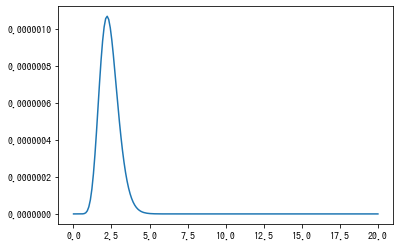

In [68]:
plt.plot(lam_list, np.exp(log_numerator)) # expをかけて、元の分子に戻す

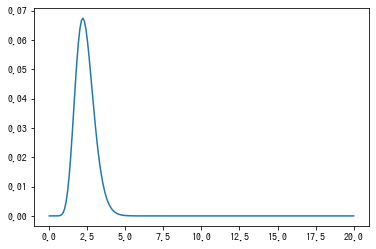

In [69]:
# 分母で調整
proba_lam = np.exp(log_numerator)/sum(np.exp(log_numerator))
plt.plot(lam_list, proba_lam)

In [83]:
# MAP推定量で予測
lam_list[np.argmax(proba_lam)] # np.argmaxで最大値を取るときの配列indexを探して、そのときのlam_listをとってくる

4.731256281407035

よってMAP推定された$\lambda$は2.22となった。

## Bさんはある機械を使っていますが、この機械は割とすぐに壊れます。今まで使った機械について、使用開始から故障までの使用月数は以下の通りでした。平均使用可能期間$\beta$は一定だとして、最尤推定を用いて$\beta$を推定して下さい。

In [1]:
t_use = [1, 21,  6, 24,  2,  7,  2,  2,  4,  2,  1,  2,  0,  7,  4,  1,  1, 1,  6,  1]

単位時間あたりの故障確率が一定のとき、故障までの期間の分布は指数分布に従う。今回の例も、指数分布で良く近似できると期待できる。  
指数分布のパラメータは平均値(または平均値の逆数$\beta$)であるので、ざっくりと平均値を計算して、あたりをつける

In [47]:
np.array(t_use).mean()

4.75

パラメータ$\beta$は1/4.75近辺になりそう(というより、今回のデータのみで最尤推定をすると、1/4.75になる。)

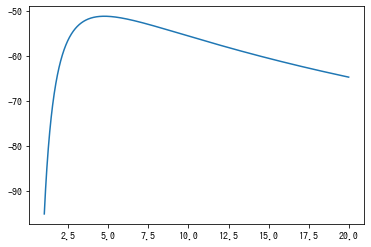

In [53]:
from scipy.stats import expon # 指数分布

x = np.linspace(1,20,1901) # パラメータの候補。1, 1.01, ..., 20

log_likelihood_list = [0] * 1901 # 対数尤度の入れ物
for i,val in enumerate(x):
    log_likelihood_list[i] = np.sum(np.log(expon.pdf(t_use, scale=val))) # 対数尤度を計算して、リストに代入

plt.plot(x, log_likelihood_list)

In [51]:
avg = x[np.argmax(log_likelihood_list)] # np.argmaxで最大値を取るときの配列indexを探して、そのときのxをとってくる
avg

4.75

In [52]:
1/avg

0.21052631578947367

よって平均値は4.75、$\beta$は0.21

In [54]:
# optimizerを使う場合
def neg_log_likelihood(val):
    return -np.sum(np.log(expon.pdf(t_use, scale=val)))

res = minimize(neg_log_likelihood, 1) # 初期値1でやってみる
res.x[0]

4.7500016616022815

## 上の問題について、ベイズ推定を用いて$\beta$を推定して下さい。事前分布は自由に考えてみてください

故障までの期間の平均値の逆数だと想像しづらいので、平均値を推定して、その逆数を取ることにする。  
故障までの平均値だが、あまり想像がつかないので、無情報事前分布である一様分布(0~200でとった)を使うことにする。

In [73]:
from scipy.stats import uniform

avg_list = np.linspace(0.01, 20, 200)  # 0.01, 0.02, .., 20
log_numerator = [0] * 200 # パラメータの事後分布確率の入れ物。パラメータの範囲は0.01, 0.02, ..., 20

for i, avg in enumerate(avg_list): # 0は除く(流れ星は発生しているので、ゼロはない)
    log_numerator[i] = np.log(expon.pdf(t_use, scale=avg)).sum() + np.log(uniform.pdf(lam, loc=0, scale=200))

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


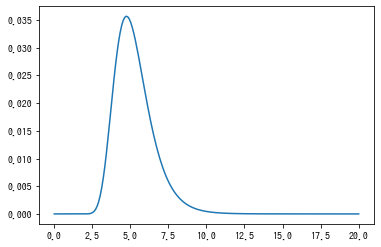

In [79]:
# 分母で調整
proba_avg = np.exp(log_numerator)/sum(np.exp(log_numerator))
plt.plot(avg_list, proba_avg)

In [81]:
# MAP推定量で予測
res = avg_list[np.argmax(proba_avg)] # np.argmaxで最大値を取るときの配列indexを探して、そのときのlam_listをとってくる
res

4.731256281407035

In [82]:
1/res

0.21136035347098311

よってMAP推定された平均値は4.73、$\beta$は0.21となった。(無情報事前分布を使用しているのに最尤推定と同じ値にならないのは、数値計算の誤差)